In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

test_df[label_name] = test_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
test_df[label_name] = encoder.transform(test_df[label_name])

In [3]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label=label_name, cat_features=cat_features)
test_ds = Dataset(test_df, label=label_name, cat_features=cat_features)

numeric_features = list(set(train_ds.features) - set(cat_features))

## Whole Dataset Drift

In [4]:
from deepchecks.checks import WholeDatasetDrift

/home/noam/deepchecks/dc_repo_venv/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Whole Dataset Drift

Calculate drift between the entire train and test datasets using a model trained to distinguish between them.

The shown features are the features that are most important for the domain classifier - the
 domain_classifier trained to distinguish between the train and test datasets. The percents of
 explained dataset difference are the calculated feature importance values for the feature.

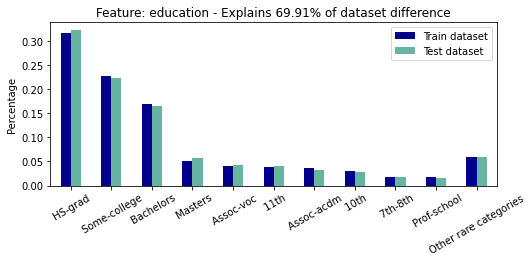

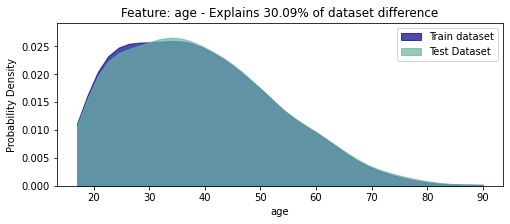

In [5]:
WholeDatasetDrift().run(train_ds, test_ds)

## Introduce drift to dataset

In [6]:
sample_size = 10000
random_seed = 0

In [7]:
train_drifted_df = pd.concat([train_ds.data.sample(min(sample_size, train_ds.n_samples) - 5000), 
                             train_ds.data[train_ds.features_columns['sex'] == ' Female'].sample(5000, random_state=random_seed)])
test_drifted_df = test_ds.data.sample(min(sample_size, test_ds.n_samples), random_state=random_seed)

train_drifted_ds = Dataset(train_drifted_df, label=label_name, cat_features=cat_features)
test_drifted_ds = Dataset(test_drifted_df, label=label_name, cat_features=cat_features)

Whole Dataset Drift

Calculate drift between the entire train and test datasets using a model trained to distinguish between them.

The shown features are the features that are most important for the domain classifier - the
 domain_classifier trained to distinguish between the train and test datasets. The percents of
 explained dataset difference are the calculated feature importance values for the feature.

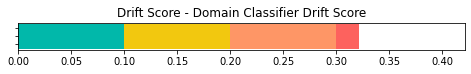

Main features contributing to drift

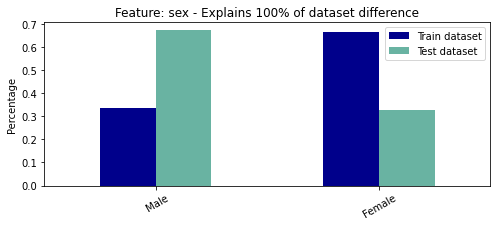

In [14]:
res = WholeDatasetDrift().run(train_drifted_ds, test_drifted_ds)
res